# Assignment on k-Means Clustering

## Problem Statement:
We have given a collection of 8 points. 

| Point | x-coordinate | y-coodinate |
| :-: | :-: | :-: |
| P1 | 0.1 | 0.6 |
| P2 | 0.15 | 0.71 |
| P3 | 0.08 | 0.9 |
| P4 | 0.16 | 0.85 |
| P5 | 0.2 | 0.3 | 
| P6 | 0.25 | 0.5 | 
| P7 | 0.24 | 0.1 | 
| P8 | 0.3 | 0.2 | 

Perform the k-mean clustering with initial centroids as m1=P1 = Cluster#1=C1 and m2=P8=cluster#2=C2 and answer the following questions based on the clusters formed
1. Which cluster does P6 belong to?
2. What is the population of cluster around m2?
3. What is updated value of m1 and m2?

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import threading
import random
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import sys

In [2]:
data = {
    'point': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8'],
    'x': [0.1, 0.15, 0.08, 0.16, 0.2, 0.25, 0.24, 0.3], 
    'y': [0.6, 0.71, 0.9, 0.85, 0.3, 0.5, 0.1, 0.2]
} 
df = pd.DataFrame.from_dict(data) 
label = "label"

In [3]:
df.head()

,point,x,y
0,P1,0.10,0.60
1,P2,0.15,0.71
2,P3,0.08,0.90
3,P4,0.16,0.85
4,P5,0.20,0.30


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,8.0,0.185,0.076345,0.08,0.1375,0.18,0.2425,0.3
y,8.0,0.520,0.298424,0.10,0.2750,0.55,0.7450,0.9


In [5]:
df.shape

(8, 3)

<AxesSubplot:xlabel='x', ylabel='y'>

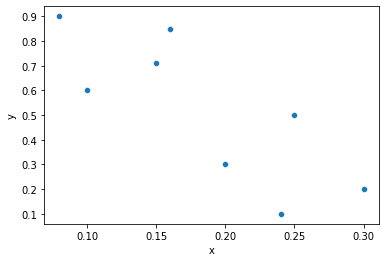

In [6]:
sns.scatterplot(data=df, x="x", y="y")

In [7]:
# Function to calculate euclidean distance between two points
def euclidean_distance(point_a, point_b):
    '''
    params: {point_a, point_b}
    - point_a, point_b : { coordinates of a point in the dataset }
    - type : list
    
    - returns: {distance}
    - distance : { Euclidean distance between point_a and point_b }
    - type: float
    '''
    distance = 0
    for i in range(len(point_a)):
        distance = distance + (point_a[i]-point_b[i])**2
    return distance**0.5

In [8]:
# Function to check if the provided parameters are correct
def check_data(data, n_clusters, centroids):
    '''
    params: {data, n_clusters, centroids}
    - data : { Input data }
    - type : list
    
    - returns: {is_valid}
    - is_valid : { True, False }
    '''
    if len(data) < n_clusters or n_clusters < 1:
        print("Number of clusters must be less than or equal to the size of input data!")
        return False
    if len(centroids) > 0 and len(centroids) != n_clusters:
        print(f"Number of clusters and centroids must be equal!")
        return False
    return True

In [9]:
# Funtion to implement K Means algorithm
def k_means(data, n_clusters, centroids=[]):
    '''
    params: {data, n_clusters, centroids}
    - data : { Input data }
    - type : list
    
    - n_clusters : {number of clusters}
    - type : int
    
    - centroids: {initial centroid points}
    - type : list
    
    - returns: {clusters, new_centroids, inertia}
    - clusters: {centroid assignment for each point in the dataset}
    - type : list
    
    - new_centroids: {final centroid points}
    - type : list  
    
    - inertia: {inertial of new centroids}
    - type : float
    
    '''
    # Initializing centroids randomly of empty array is passsed
    if len(centroids) == 0: centroids =  random.sample(data, n_clusters) 
    while True:
        inertia = 0
        clusters = {f"cluster_{k}": [] for k in range(n_clusters)}
        # Calculating distance between centroids and each point in the dataset 
        for point in data:
            distance = []
            for centroid in centroids:
                distance.append(euclidean_distance(point, centroid))
            # Evaluating the nearest centroid for each data point
            min_distance = distance.index(min(distance))
            clusters[f"cluster_{min_distance}"].append(point)
            inertia += min(distance)**2
        new_centroids = []
        # Calculating coordinates of new centroids
        for i in clusters:
            new_centroids.append([float(sum(col))/len(col) for col in zip(*clusters[i])])
        if  sorted(centroids) == sorted(new_centroids):
            return clusters, centroids, inertia
        else: centroids = new_centroids

In [10]:
# Funtion to plot clusters 
def plot_clusters(centroids, clusters):
    '''
    - pararms: {clusters, centroids}
    - clusters: {centroid assignment for each point in the dataset}
    - type : list
    
    - centroids: {initial centroid points}
    - type : list  
    '''
    # Plotting points in each cluster
    for i in clusters:
        cluster = np.array(clusters[i])
        x, y = cluster.T
        plt.scatter(x, y, label=i)
    # Plotting centroids for each cluster
    for centroid in centroids:
        x, y = np.array(centroid).T
        plt.scatter(x, y, s=200, c='yellow')
    plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
    plt.title('Clusters')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.legend()
    plt.show()

In [11]:
# Function to determine max k value for elbow method
def evaluate_max_k(length):
    if length > 10:
        if length**0.5 < 10:
            return 10
        else:
            return length**0.5
    else:
        return length

In [12]:
# Wrapper function for implementing k-means using threads
def wrapper(data, n_clusters, wcss, centroids):
    _, _, inertia = k_means(data, n_clusters, centroids)
    wcss[n_clusters-1] = inertia

In [13]:
# Function to parallelly implement multiple instances of kmeans to calculate wcss for different k values 
def get_wcss(data, n_centroids):
    threads = []
    max_k = evaluate_max_k(len(data))
    k = range(1,max_k)
    wcss =  [None]*len(k)
    for n_clusters in k:
        process = threading.Thread(target=wrapper, args=(data, n_clusters, wcss, n_centroids))
        process.start()
        threads.append(process)
    for process in threads:
        process.join()
    return k, wcss

In [14]:
# Function to plot elbow curve
def plot_elbow_curve(k, wcss):
    plt.figure(figsize=(8,8))
    plt.plot(k, wcss, marker='o',ms = 10, mfc = 'red')
    plt.title('Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

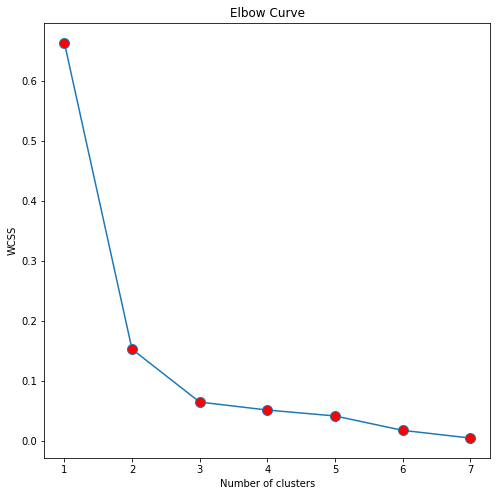

In [15]:
df_list = df[['x','y']].values.tolist()
k, wcss = get_wcss(df_list, n_centroids=[])
plot_elbow_curve(k, wcss)

From the elbow curve why try to find out a point known as the elbow point.

Enter number of clusters: 2


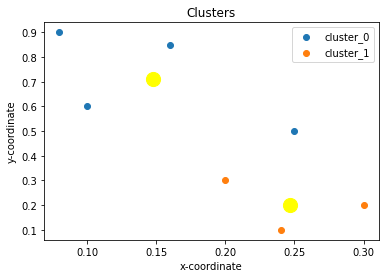

In [16]:
n_clusters = int(input("Enter number of clusters: "))
centroids = [[0.1, 0.6], [0.3, 0.2]]
clusters, centroids, inertia = k_means(df_list, n_clusters, centroids)
plot_clusters(centroids, clusters)

In [17]:
print("Centroids: ",centroids)

Centroids:  [[0.148, 0.712], [0.24666666666666667, 0.20000000000000004]]


## Sklearn Implementation

In [18]:
X_num = df[['x','y']].to_numpy()
centroids_num = np.array(centroids) if len(centroids) != 0 else 'random'

In [19]:
kmeans = KMeans(n_clusters = n_clusters, init = centroids_num)
Y_kmeans = kmeans.fit_predict(X_num)

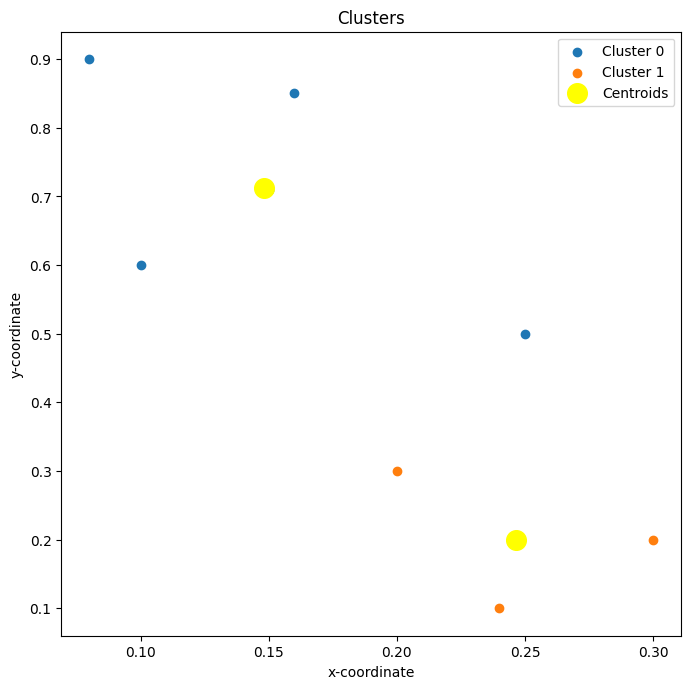

In [20]:
for i in range(n_clusters):
    plt.scatter(X_num[Y_kmeans == i,0], X_num[Y_kmeans == i,1], label = f'Cluster {i}') 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c='yellow', label= 'Centroids')
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
plt.title('Clusters')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend()
plt.show()

## Disadvantages: 
- Inherently, K-means is NP-hard. For $d$ dimensions, $k$ clusters, and $n$ observations, we will find a solution in $O(n^{d k+1})$ time.
- Sensitive to initial conditions and outliers.
- Curse of dimensionality: K Means suffers from the curse of dimensionality as the number of dimensions increases, a distance-based similarity measure converges to a constant value between any given examples.

## Conclusion:

K Means Clustering algorithm was used for clustering the points given in the dataset.